# Model evaluation

## General Data Wrangling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PowerTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import altair as alt
alt.renderers.enable('mimetype')
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

In [2]:
import sys
sys.path.append('code/')
from functions import *

In [3]:
data_full = pd.read_csv( '../01-data/data_merged_20220910_norm.csv')
data_full = data_full.query('H_Age<100&Draw>0').reset_index( drop = True)
y = data_full[ 'Winner']

C:\Users\User\AppData\Local\Temp\ipykernel_12084\2406342619.py:1: DtypeWarning: Columns (62) have mixed types. Specify dtype option on import or set low_memory=False.
  data_full = pd.read_csv( '../01-data/data_merged_20220910_norm.csv')


In [4]:
X = data_full.loc[ :, data_full.columns.str.startswith( 'ActualWeight') | data_full.columns.str.startswith( 'DeclaredHorseWeight') | \
    data_full.columns.str.startswith( 'WinOdds') | data_full.columns.str.startswith( 'Draw') | \
    data_full.columns.str.startswith( 'J_Total_') | data_full.columns.str.startswith( 'J_TotalStakes_') | \
    data_full.columns.str.startswith( 'J_Rate_') | \
    data_full.columns.str.startswith( 'T_Total_') | data_full.columns.str.startswith( 'T_TotalStakes_') | \
    data_full.columns.str.startswith( 'T_Rate') | \
    data_full.columns.str.startswith( 'H_Rate_') | data_full.columns.str.startswith( 'H_Total') | \
    data_full.columns.str.startswith( 'H_TotalStake') | data_full.columns.str.startswith( 'CombinedRating') | \
    data_full.columns.str.startswith( 'H_Age') | data_full.columns.str.startswith( 'WeightDiff') | \
    data_full.columns.str.startswith( 'LastRace_nDays') | data_full.columns.str.startswith( 'PreviousPlace') | \
    data_full.columns.str.startswith( 'AvgPlace3') | data_full.columns.str.startswith( 'AvgPlace5') | \
    data_full.columns.str.startswith( 'Place')] # Place is added for downsampling

print( X.columns)

Index(['Place', 'ActualWeight', 'DeclaredHorseWeight', 'Draw', 'WinOdds',
       'J_Rate_win', 'J_Rate_place', 'J_Rate_show', 'T_Rate_win',
       'T_Rate_place', 'T_Rate_show', 'H_TotalStake', 'H_Total', 'H_Rate_win',
       'H_Rate_place', 'H_Rate_show', 'H_Age', 'LastRace_nDays',
       'PreviousPlace', 'AvgPlace3', 'AvgPlace5', 'WeightDiff',
       'CombinedRating', 'Place_norm', 'ActualWeight_norm',
       'DeclaredHorseWeight_norm', 'Draw_norm', 'WinOdds_norm',
       'J_Rate_win_norm', 'J_Rate_place_norm', 'J_Rate_show_norm',
       'T_Rate_win_norm', 'T_Rate_place_norm', 'T_Rate_show_norm',
       'H_TotalStake_norm', 'H_Total_norm', 'H_Rate_win_norm',
       'H_Rate_place_norm', 'H_Rate_show_norm', 'H_Age_norm',
       'LastRace_nDays_norm', 'PreviousPlace_norm', 'AvgPlace3_norm',
       'AvgPlace5_norm', 'WeightDiff_norm', 'CombinedRating_norm'],
      dtype='object')


In [5]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.8, random_state = 918)

Variables and corresponding transformations. (All relative indexes will not be transformed as they are theoretically normal)


| Variable | Log? | Scaling |
|----------|------|---------|
| ActualWeight | No | Standard |
| DeclaredHorseWeight | No | Standard |
| Draw | No | Standard (_Ordinal_+Scaling) |
| WinOdds | Yes  |Standard |
| J_Rate_* | No | None |
| T_Rate_* | No | None |
| H_TotalStake | Yes | Standard |
| H_Total | Yes | Standard |
| H_Rate_* | No | None |
| H_Age | No | Standard |
| LastRace_nDays | Yes | Standard |
| PreviousPlace | No | Standard |
| AvgPlace* | No | Standard |
| WeightDiff | No | Standard |
| Rating | No | Standard |


In [6]:
cols_std = [
    'ActualWeight', 'DeclaredHorseWeight', 'Draw', 'H_Age', 'PreviousPlace', 'AvgPlace3', 'AvgPlace5', 'WeightDiff', 'CombinedRating']

cols_log_std = [
    'WinOdds', 'H_TotalStake', 'H_Total', 'LastRace_nDays']

cols_passthrough = [
    'J_Rate_win', 'J_Rate_place', 'J_Rate_show', 'T_Rate_win', 'T_Rate_place', 'T_Rate_show',
    'H_Rate_win', 'H_Rate_place', 'H_Rate_show',
    'ActualWeight_norm', 'DeclaredHorseWeight_norm', 'WinOdds_norm',
    'J_Rate_win_norm', 'J_Rate_place_norm', 'J_Rate_show_norm', 'T_Rate_win_norm', 'T_Rate_place_norm', 'T_Rate_show_norm',
    'H_TotalStake_norm', 'H_Total_norm', 'H_Rate_win_norm', 'H_Rate_place_norm', 'H_Rate_show_norm', 'H_Age_norm',
    'LastRace_nDays_norm', 'PreviousPlace_norm', 'AvgPlace3_norm', 'AvgPlace5_norm', 'WeightDiff_norm', 'CombinedRating_norm']

cols_drop = [
    'Place', 'Place_norm', 'Draw_norm']

In [7]:
def log_func(x):
    return np.log(x+1)

In [8]:
log_transformer = FunctionTransformer( log_func)

In [9]:
pipe_log_std = make_pipeline(
    log_transformer, StandardScaler()
)

In [10]:
column_transformer = make_column_transformer(
    ( StandardScaler(), cols_std),
    ( pipe_log_std, cols_log_std),
    ( 'passthrough', cols_passthrough),
    ( 'drop', cols_drop)
)

## KNN

### Model training

In [11]:
pipe_knn = make_pipeline( column_transformer, KNeighborsClassifier())

In [12]:
cv_result_knn = cross_validate( pipe_knn, X_train, y_train, cv = 5, return_train_score = True, scoring = 'precision')

In [13]:
pd.DataFrame( cv_result_knn).mean()

fit_time       0.048770
score_time     0.227011
test_score     0.339391
train_score    0.697039
dtype: float64

### Hyperparameter optimization

In [14]:
param_grid = {
    "kneighborsclassifier__n_neighbors": list( range( 5, 35, 5))
}

grid_search_knn = GridSearchCV(
    pipe_knn, param_grid, cv = 5, scoring = 'average_precision', n_jobs=-1, return_train_score = True
)

In [15]:
grid_search_knn.fit( X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['ActualWeight',
                                                                          'DeclaredHorseWeight',
                                                                          'Draw',
                                                                          'H_Age',
                                                                          'PreviousPlace',
                                                                          'AvgPlace3',
                                                                          'AvgPlace5',
                                                                          'WeightDiff',
                                                                          'CombinedRating']),
                                                                        ('pipeline',
                                                                         Pipeline(steps=[('functiontransformer',
                                                                                          FunctionTransformer(func=<function log_func...
                                                                          'LastRace_nDays_norm',
                                                                          'PreviousPlace_norm',
                                                                          'AvgPlace3_norm',
                                                                          'AvgPlace5_norm',
                                                                          'WeightDiff_norm',
                                                                          'CombinedRating_norm']),
                                                                        ('drop',
                                                                         'drop',
                                                                         ['Place',
                                                                          'Place_norm',
                                                                          'Draw_norm'])])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': [5, 10, 15, 20,
                                                               25, 30]},
             return_train_score=True, scoring='average_precision')

In [16]:
cv_results_knn_opt = pd.DataFrame( grid_search_knn.cv_results_)
cv_results_knn_opt[ ['params', 'mean_test_score']].sort_values( 'mean_test_score', ascending = False)

,params,mean_test_score
5,{'kneighborsclassifier__n_neighbors': 30},0.289263
4,{'kneighborsclassifier__n_neighbors': 25},0.280416
3,{'kneighborsclassifier__n_neighbors': 20},0.257366
2,{'kneighborsclassifier__n_neighbors': 15},0.246969
1,{'kneighborsclassifier__n_neighbors': 10},0.229129
0,{'kneighborsclassifier__n_neighbors': 5},0.176297


### Final model evaluation

In [17]:
grid_search_knn.best_params_

{'kneighborsclassifier__n_neighbors': 30}

In [18]:
pipe_knn_opt = make_pipeline( column_transformer,
                              KNeighborsClassifier( n_neighbors = grid_search_knn.best_params_[ 'kneighborsclassifier__n_neighbors']))

In [19]:
pipe_knn_opt.fit( X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['ActualWeight',
                                                   'DeclaredHorseWeight',
                                                   'Draw', 'H_Age',
                                                   'PreviousPlace', 'AvgPlace3',
                                                   'AvgPlace5', 'WeightDiff',
                                                   'CombinedRating']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function log_func at 0x000001A8E5F01550>)),
                                                                  ('st...
                                                   'T_Rate_show_norm',
                                                   'H_TotalStake_norm',
                                                   'H_Total_norm',
                                                   'H_Rate_win_norm',
                                                   'H_Rate_place_norm',
                                                   'H_Rate_show_norm',
                                                   'H_Age_norm',
                                                   'LastRace_nDays_norm',
                                                   'PreviousPlace_norm',
                                                   'AvgPlace3_norm',
                                                   'AvgPlace5_norm',
                                                   'WeightDiff_norm',
                                                   'CombinedRating_norm']),
                                                 ('drop', 'drop',
                                                  ['Place', 'Place_norm',
                                                   'Draw_norm'])])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=30))])

In [20]:
y_hat_knn_opt = pipe_knn_opt.predict( X_test)

In [21]:
better_confusion_matrix( y_test, y_hat_knn_opt, labels = [ True, False])

Predicted       
                  True  False
Actual True         36   1048
       False        20  12011

In [22]:
print( classification_report( y_test, y_hat_knn_opt))

              precision    recall  f1-score   support

       False       0.92      1.00      0.96     12031
        True       0.64      0.03      0.06      1084

    accuracy                           0.92     13115
   macro avg       0.78      0.52      0.51     13115
weighted avg       0.90      0.92      0.88     13115



## SVC

### Model training

In [23]:
pipe_svc = make_pipeline( column_transformer, SVC())

In [24]:
cv_result_svc = cross_validate( pipe_svc, X_train, y_train, cv = 5, return_train_score = True, scoring = 'precision')
pd.DataFrame( cv_result_svc)

,fit_time,score_time,test_score,train_score
0,0.548317,0.279690,1.000000,0.952381
1,0.498167,0.186001,0.500000,0.962963
2,0.591357,0.252614,0.750000,1.000000
3,0.387107,0.170211,0.666667,0.952381
4,0.511307,0.173446,1.000000,1.000000


In [25]:
pd.DataFrame( cv_result_svc).mean()

fit_time       0.507251
score_time     0.212393
test_score     0.783333
train_score    0.973545
dtype: float64

### Hyperparameter optimization

In [26]:
param_dist = {
    'svc__C': [ 10**x for x in range( -2, 5)],
    'svc__gamma': [ 10**x for x in range( -2, 5)]
}

random_search_svc = RandomizedSearchCV(
    pipe_svc, param_dist, n_iter = 20, cv = 5, scoring = 'average_precision', n_jobs=-1, return_train_score = True, random_state = 918
)

In [27]:
random_search_svc.fit( X_train, y_train)
cv_results_svc_opt = pd.DataFrame( random_search_svc.cv_results_)
cv_results_svc_opt[ ['params', 'mean_test_score']].sort_values( 'mean_test_score', ascending = False).head()

,params,mean_test_score
0,"{'svc__gamma': 0.01, 'svc__C': 1}",0.322594
1,"{'svc__gamma': 0.01, 'svc__C': 0.1}",0.321791
9,"{'svc__gamma': 0.1, 'svc__C': 100}",0.249667
2,"{'svc__gamma': 0.01, 'svc__C': 10000}",0.220288
15,"{'svc__gamma': 1, 'svc__C': 0.01}",0.152376


In [28]:
random_search_svc.best_params_

{'svc__gamma': 0.01, 'svc__C': 1}

### Threshold tuning

In [29]:
X_cv_train, X_cv_test, y_cv_train, y_cv_test = train_test_split( X_train, y_train, test_size = 0.2, stratify = y_train, random_state = 918)

In [30]:
pipe_svc_opt = make_pipeline( column_transformer,
                              SVC( gamma = random_search_svc.best_params_[ 'svc__gamma'],
                                   C = random_search_svc.best_params_[ 'svc__C']))

Best params are {'svc__gamma': 0.1, 'svc__C': 1}. No need to re-fit every time.

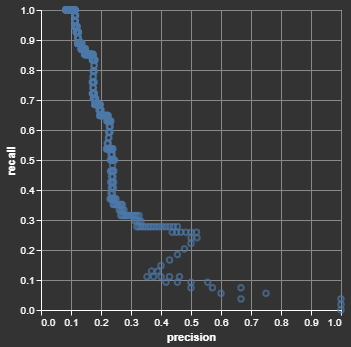

In [31]:
pr_curve( pipe_svc_opt, X_cv_train, X_cv_test, y_cv_train, y_cv_test)

A threshold of -0.75 is selected.

### Final model evaluation

In [32]:
def svc_by_proba( pipe_svc, X_test, threshold):
    proba = pipe_svc.decision_function( X_test)
    y_hat = proba > threshold
    return y_hat

In [33]:
pipe_svc_opt.fit( X_train, y_train)
y_hat_svc_opt = svc_by_proba( pipe_svc_opt, X_test, -0.75)
better_confusion_matrix( y_test, y_hat_svc_opt, labels = [ True, False])

Predicted       
                  True  False
Actual True         65   1019
       False        21  12010

In [34]:
print( classification_report( y_test, y_hat_svc_opt))

              precision    recall  f1-score   support

       False       0.92      1.00      0.96     12031
        True       0.76      0.06      0.11      1084

    accuracy                           0.92     13115
   macro avg       0.84      0.53      0.53     13115
weighted avg       0.91      0.92      0.89     13115



## Random Forest Classifier

### Model training

In [35]:
pipe_rfc = make_pipeline( column_transformer, RandomForestClassifier())
cv_result_rfc = cross_validate( pipe_rfc, X_train, y_train, cv = 5, return_train_score = True, scoring = 'precision')
pd.DataFrame( cv_result_rfc)

,fit_time,score_time,test_score,train_score
0,3.863013,0.098872,0.714286,1.0
1,2.357111,0.096233,0.444444,1.0
2,2.694180,0.049897,0.666667,1.0
3,2.456637,0.058067,0.444444,1.0
4,2.387366,0.078216,0.500000,1.0


In [36]:
pd.DataFrame( cv_result_rfc).mean()

fit_time       2.751661
score_time     0.076257
test_score     0.553968
train_score    1.000000
dtype: float64

### Hyperparameter optimization

In [37]:
param_dist = {
    'randomforestclassifier__n_estimators': [ 100*x for x in range( 1, 11)],
    'randomforestclassifier__max_depth': [ 10*x for x in range( 1, 11)],
    'randomforestclassifier__max_features': [ 'sqrt', 'log2'],
    'randomforestclassifier__criterion': [ 'gini', 'entropy', 'log_loss'],
    'randomforestclassifier__bootstrap': [ True, False]
}

random_search_rfc = RandomizedSearchCV(
    pipe_rfc, param_dist, n_iter = 30, cv = 5, scoring = 'precision', n_jobs=-1, return_train_score = True, random_state = 918
)

random_search_rfc.fit( X_train, y_train)
cv_results_rfc_opt = pd.DataFrame( random_search_rfc.cv_results_)
cv_results_rfc_opt[ ['params', 'mean_test_score']].sort_values( 'mean_test_score', ascending = False).head()

,params,mean_test_score
16,"{'randomforestclassifier__n_estimators': 200, ...",0.711190
26,"{'randomforestclassifier__n_estimators': 300, ...",0.580397
24,"{'randomforestclassifier__n_estimators': 900, ...",0.576825
19,"{'randomforestclassifier__n_estimators': 100, ...",0.570159
0,"{'randomforestclassifier__n_estimators': 700, ...",0.569683


In [38]:
random_search_rfc.best_params_

{'randomforestclassifier__n_estimators': 200,
 'randomforestclassifier__max_features': 'log2',
 'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__bootstrap': True}

### Threshold tuning

In [39]:
pipe_rfc_opt = make_pipeline( column_transformer,
                              RandomForestClassifier( n_estimators = random_search_rfc.best_params_[ 'randomforestclassifier__n_estimators'],
                                                      max_features = random_search_rfc.best_params_[ 'randomforestclassifier__max_features'],
                                                      max_depth = random_search_rfc.best_params_[ 'randomforestclassifier__max_depth'],
                                                      criterion = random_search_rfc.best_params_[ 'randomforestclassifier__criterion'],
                                                      bootstrap = random_search_rfc.best_params_[ 'randomforestclassifier__bootstrap']))

Best params are {'randomforestclassifier__n_estimators': 300,
 'randomforestclassifier__max_features': 'log2',
 'randomforestclassifier__max_depth': 90,
 'randomforestclassifier__criterion': 'log_loss',
 'randomforestclassifier__bootstrap': True}. No need to re-fit every time.

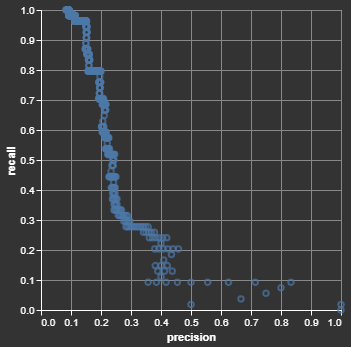

In [40]:
pr_curve( pipe_rfc_opt, X_cv_train, X_cv_test, y_cv_train, y_cv_test)

A threshold of 0.58 is selected.

### Final model evaluation

In [41]:
def rfc_by_proba( pipe_rfc, X_test, threshold):
    proba = pipe_rfc.predict_proba( X_test)[ :, 1]
    y_hat = proba > threshold
    return y_hat

In [42]:
pipe_rfc_opt.fit( X_train, y_train)
y_hat_rfc_opt = rfc_by_proba( pipe_rfc_opt, X_test, 0.58)
better_confusion_matrix( y_test, y_hat_rfc_opt, labels = [ True, False])

Predicted       
                  True  False
Actual True         53   1031
       False        17  12014

In [43]:
print( classification_report( y_test, y_hat_rfc_opt))

              precision    recall  f1-score   support

       False       0.92      1.00      0.96     12031
        True       0.76      0.05      0.09      1084

    accuracy                           0.92     13115
   macro avg       0.84      0.52      0.53     13115
weighted avg       0.91      0.92      0.89     13115



## Gaussian Naive Bayes

### Model training

In [44]:
pipe_nb = make_pipeline( column_transformer, PowerTransformer(), GaussianNB())
cv_result_nb = cross_validate( pipe_nb, X_train, y_train, cv = 5, return_train_score = True, scoring = 'precision')
pd.DataFrame( cv_result_nb)

,fit_time,score_time,test_score,train_score
0,0.578163,0.028541,0.198895,0.214080
1,0.614964,0.054981,0.185185,0.216495
2,0.941294,0.047930,0.227848,0.207574
3,0.632829,0.044298,0.207792,0.210904
4,0.597413,0.024360,0.213115,0.204906


In [45]:
pd.DataFrame( cv_result_svc).mean()

fit_time       0.507251
score_time     0.212393
test_score     0.783333
train_score    0.973545
dtype: float64

### Threshold tuning

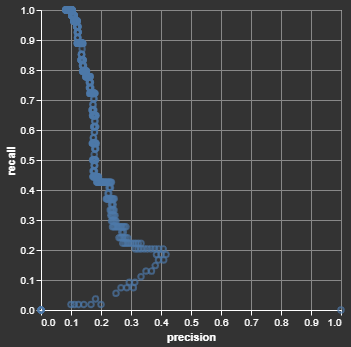

In [46]:
pr_curve( pipe_nb, X_cv_train, X_cv_test, y_cv_train, y_cv_test)

A threshold of 0.999999 is selected.

### Final model evaluation

In [47]:
def nb_by_proba( pipe_nb, X_test, threshold):
    proba = pipe_nb.predict_proba( X_test)[ :, 1]
    y_hat = proba > threshold
    return y_hat
pipe_nb.fit( X_train, y_train)
y_hat_nb = nb_by_proba( pipe_nb, X_test, 0.999999)
better_confusion_matrix( y_test, y_hat_nb, labels = [ True, False])

Predicted       
                  True  False
Actual True        214    870
       False       286  11745

In [48]:
print( classification_report( y_test, y_hat_nb))

              precision    recall  f1-score   support

       False       0.93      0.98      0.95     12031
        True       0.43      0.20      0.27      1084

    accuracy                           0.91     13115
   macro avg       0.68      0.59      0.61     13115
weighted avg       0.89      0.91      0.90     13115



## Logistic Regression

### Model training

In [49]:
pipe_logreg = make_pipeline( column_transformer, LogisticRegression( max_iter = 500, solver = 'saga'))
cv_result_logreg = cross_validate( pipe_logreg, X_train, y_train, cv = 5, return_train_score = True, scoring = 'precision')
pd.DataFrame( cv_result_logreg)

,fit_time,score_time,test_score,train_score
0,1.279796,0.040390,0.666667,0.567568
1,1.073148,0.024384,0.421053,0.616438
2,1.490696,0.016783,0.541667,0.578125
3,1.112510,0.019061,0.538462,0.579710
4,1.197296,0.017444,0.692308,0.582090


In [50]:
pd.DataFrame( cv_result_logreg).mean()

fit_time       1.230689
score_time     0.023612
test_score     0.572031
train_score    0.584786
dtype: float64

### Hyperparameter optimization

In [51]:
param_dist = {
    'logisticregression__C': [ 10**x for x in range( -2, 5)],
    'logisticregression__penalty': [ 'none', 'l2', 'l1', 'elasticnet'],
    'logisticregression__l1_ratio': [ 0, 0.5, 1]
}

grid_search_logreg = GridSearchCV(
    pipe_logreg, param_dist, cv = 5, scoring = 'precision', n_jobs=-1, return_train_score = True
)

grid_search_logreg.fit( X_train, y_train)
cv_results_logreg_opt = pd.DataFrame( grid_search_logreg.cv_results_)
cv_results_logreg_opt[ ['params', 'mean_test_score']].sort_values( 'mean_test_score', ascending = False).head()

C:\Users\User\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


,params,mean_test_score
3,"{'logisticregression__C': 0.01, 'logisticregre...",0.666667
5,"{'logisticregression__C': 0.01, 'logisticregre...",0.666667
1,"{'logisticregression__C': 0.01, 'logisticregre...",0.666667
9,"{'logisticregression__C': 0.01, 'logisticregre...",0.666667
23,"{'logisticregression__C': 0.1, 'logisticregres...",0.604664


In [52]:
grid_search_logreg.best_params_

{'logisticregression__C': 0.01,
 'logisticregression__l1_ratio': 0,
 'logisticregression__penalty': 'l2'}

### Threshold tuning

In [53]:
pipe_logreg_opt = make_pipeline( column_transformer,
                                 LogisticRegression( max_iter = 500,
                                                     solver = 'saga',
                                                     C = grid_search_logreg.best_params_[ 'logisticregression__C'],
                                                     penalty = grid_search_logreg.best_params_[ 'logisticregression__penalty'],
                                                     l1_ratio = grid_search_logreg.best_params_[ 'logisticregression__l1_ratio']))

C:\Users\User\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


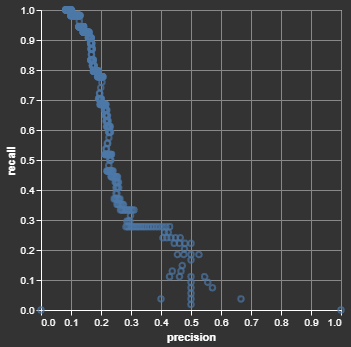

In [54]:
pr_curve( pipe_logreg_opt, X_cv_train, X_cv_test, y_cv_train, y_cv_test)

A threshold of 0.38 is selected.

### Final model evaluation

In [55]:
def logreg_by_proba( pipe_logreg, X_test, threshold):
    proba = pipe_logreg.predict_proba( X_test)[ :, 1]
    y_hat = proba > threshold
    return y_hat
pipe_logreg_opt.fit( X_train, y_train)
y_hat_logreg_opt = logreg_by_proba( pipe_logreg_opt, X_test, 0.38)
better_confusion_matrix( y_test, y_hat_logreg_opt, labels = [ True, False])

C:\Users\User\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Predicted       
                  True  False
Actual True        185    899
       False       129  11902

In [56]:
print( classification_report( y_test, y_hat_logreg_opt))

              precision    recall  f1-score   support

       False       0.93      0.99      0.96     12031
        True       0.59      0.17      0.26      1084

    accuracy                           0.92     13115
   macro avg       0.76      0.58      0.61     13115
weighted avg       0.90      0.92      0.90     13115

